# SST in Bavi, Mayas, Haishen
  
Authors
* [Dr Chelle Gentemann](mailto:gentemann@faralloninstitute.org)    - Farallon Institute, USA


## In Feb 2020 a GRL [paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020GL091430) came out connecting 3 closely occuring Typhoons near Korea to the California wildfires
  
"Strong winds that accentuated a fire outbreak in the western United States in early September of 2020 resulted from an atmospheric wave train that spanned the Pacific Ocean. Days before the atmospheric waves developed in the United States, three western Pacific tropical cyclones (typhoons) underwent an extratropical transition over Korea within an unprecedentedly short span of 12 days. "

Figure 1 showed zonal winds averaged over a box located over NCal/Oregon. On 9/5 and again on 9/24 the zonal winds were strongly negative (Diablo winds) and both events had major fires.
  

-------------------

## Import python packages

* You are going to want numpy, pandas, matplotlib.pyplot, podaaacpy, and xarray
* This cell also imports a parser so that a login file can be read to use podaacpy

In [1]:
#!pip install xhistogram
#!pip install eofs
!pip install lxml

import warnings
warnings.simplefilter('ignore') # filter some warning messages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

#This is for reading in and parsing the login file credentials
from pathlib import Path
import configparser
from lxml import objectify
from xhistogram.xarray import histogram
from scipy import signal

plt.rcParams["figure.figsize"] = (15,8)
#rcParams['figure.figsize'] = 5, 10

## Analysis of SSTs during Typhoons in 2020 near Korea


# Read in Storm data from a thredds server
- Note update - the thredds server has disappeared, so I have left the url in the code, but commented out and replaced it with a local copy of the data.  

In [2]:
#url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.WP.v04r00.nc'
url = './../data/IBTrACS.WP.v04r00.nc'

ds_storm=xr.open_dataset(url)

# the data isn't formatted very well & have to convert strings
for var in ds_storm:
    if not((ds_storm[var].dtype=='float32') or (ds_storm[var].dtype=='int16')):
        ds_storm[var]=ds_storm[var].astype(str)

#calculate max_wind for each storm, as an easy way to classify them
ds_storm['max_wind']=ds_storm.usa_wind.max(dim='date_time',skipna=True)
ds_storm['max_cat']=ds_storm.usa_sshs.max(dim='date_time',skipna=True)

ds_storm

<xarray.Dataset>
Dimensions:           (date_time: 360, quadrant: 4, storm: 4209)
Coordinates:
    time              (storm, date_time) datetime64[ns] ...
    lat               (storm, date_time) float32 ...
    lon               (storm, date_time) float32 ...
Dimensions without coordinates: date_time, quadrant, storm
Data variables: (12/149)
    numobs            (storm) float32 ...
    sid               (storm) <U13 '1884177N17124' ... '2021048N07133'
    season            (storm) float32 ...
    number            (storm) int16 ...
    basin             (storm, date_time) <U2 'WP' 'WP' 'WP' 'WP' ... '' '' '' ''
    subbasin          (storm, date_time) <U2 'MM' 'MM' 'MM' 'MM' ... '' '' '' ''
    ...                ...
    usa_seahgt        (storm, date_time) float32 ...
    usa_searad        (storm, date_time, quadrant) float32 ...
    storm_speed       (storm, date_time) float32 ...
    storm_dir         (storm, date_time) float32 ...
    max_wind          (storm) float32 nan nan nan nan ... 115.0 39.0 29.0 45.0
    max_cat           (storm) float32 -1.0 -1.0 -1.0 -1.0 ... 4.0 0.0 -1.0 0.0
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [3]:
#list the storms and dates for west pacific year
sub = ds_storm.where((ds_storm.basin=='WP') & (ds_storm.max_cat>=3) & (ds_storm.season==2017),drop=True)
for i in range(len(sub.name)):
    print(sub.time[i,0].data,sub.name[i,0].data,sub.max_cat[i,0].data)
#list the storms and dates for west pacific year
sub = ds_storm.where((ds_storm.basin=='WP') & (ds_storm.max_cat>=3) & (ds_storm.season==2018),drop=True)
for i in range(len(sub.name)):
    print(sub.time[i,0].data,sub.name[i,0].data,sub.max_cat[i,0].data)
#list the storms and dates for west pacific year
sub = ds_storm.where((ds_storm.basin=='WP') & (ds_storm.max_cat>=3) & (ds_storm.season==2019),drop=True)
for i in range(len(sub.name)):
    print(sub.time[i,0].data,sub.name[i,0].data,sub.max_cat[i,0].data)
#list the storms and dates for west pacific year
sub = ds_storm.where((ds_storm.basin=='WP') & (ds_storm.max_cat>=3) & (ds_storm.season==2020),drop=True)
for i in range(len(sub.name)):
    print(sub.time[i,0].data,sub.name[i,0].data,sub.max_cat[i,0].data)

2017-07-19T06:00:00.000039936 NORU 4.0
2017-08-10T12:00:00.000039936 BANYAN 3.0
2017-08-19T12:00:00.000039936 HATO 3.0
2017-09-08T12:00:00.000039936 TALIM 4.0
2017-10-15T00:00:00.000039936 LAN 4.0
2018-03-23T06:00:00.000039936 JELAWAT 4.0
2018-07-03T00:00:00.000039936 MARIA 5.0
2018-07-31T12:00:00.000039936 nan nan
2018-08-15T00:00:00.000039936 SOULIK 3.0
2018-08-16T12:00:00.000039936 CIMARON 4.0
2018-08-26T18:00:00.000039936 JEBI 5.0
2018-09-06T12:00:00.000039936 MANGKHUT 5.0
2018-09-20T06:00:00.000039936 TRAMI 5.0
2018-09-27T12:00:00.000039936 KONG-REY 5.0
2018-10-20T18:00:00.000039936 YUTU 5.0
2019-02-18T12:00:00.000039936 WUTIP 5.0
2019-08-02T06:00:00.000039936 LEKIMA 4.0
2019-08-04T00:00:00.000039936 KROSA 3.0
2019-08-30T06:00:00.000039936 nan nan
2019-08-30T12:00:00.000039936 LINGLING 4.0
2019-10-04T12:00:00.000039936 HAGIBIS 5.0
2019-10-17T06:00:00.000039936 BUALOI 5.0
2019-10-28T12:00:00.000039936 BULBUL:MATMO 3.0
2019-11-01T12:00:00.000039936 HALONG 5.0
2019-11-09T18:00:00.000

# find the storm data for 2020 storms we are interested in 

In [4]:
storm_list,ilist = ['BAVI','MAYSAK','HAISHEN'],[]
for name in storm_list:
    iloc = np.where((ds_storm.name==name) & (ds_storm.time>np.datetime64('2020-07-01')))[0][0]
    print(name,iloc)
    ilist.append(iloc)

BAVI 4190
MAYSAK 4191
HAISHEN 4192


# plot the storm tracks

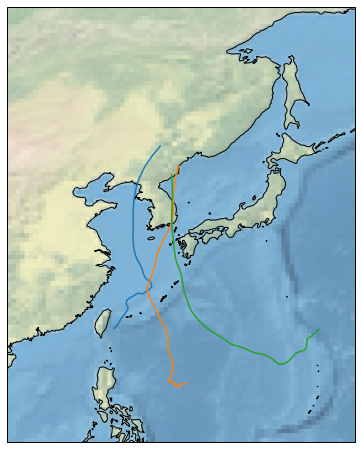

In [5]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
for i in ilist:
    ax.plot(ds_storm.lon[i,:],ds_storm.lat[i,:], transform=ccrs.PlateCarree())
ax.set_extent([110, 150, 10, 60], crs=ccrs.PlateCarree())
ax.coastlines('50m')
ax.stock_img()

In [6]:
subset_storms = ds_storm.isel(storm=ilist)
#subset_storms

# where do big storms start out?  only look at 1980 to present (data goes back to 1945)

- plot the first point the typhoon is classified as a storm, color is max_wnd

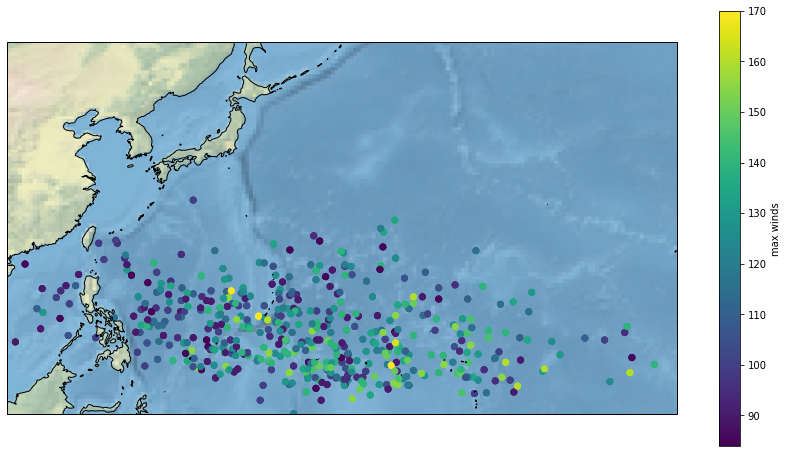

In [8]:
ds_storm['yr']=ds_storm.time[:,0].dt.year
big = ds_storm.where((ds_storm.max_wind>80) & (ds_storm.yr>1980),drop=True)
#bigax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
for i in ilist:
    plt.scatter(big.lon[:,0],big.lat[:,0],c=big.max_wind,transform=ccrs.PlateCarree())
ax.set_extent([110, 200, 0, 50], crs=ccrs.PlateCarree())
ax.coastlines('50m')
ax.stock_img()
plt.colorbar(label='max winds')

# How are big storms varying over time?

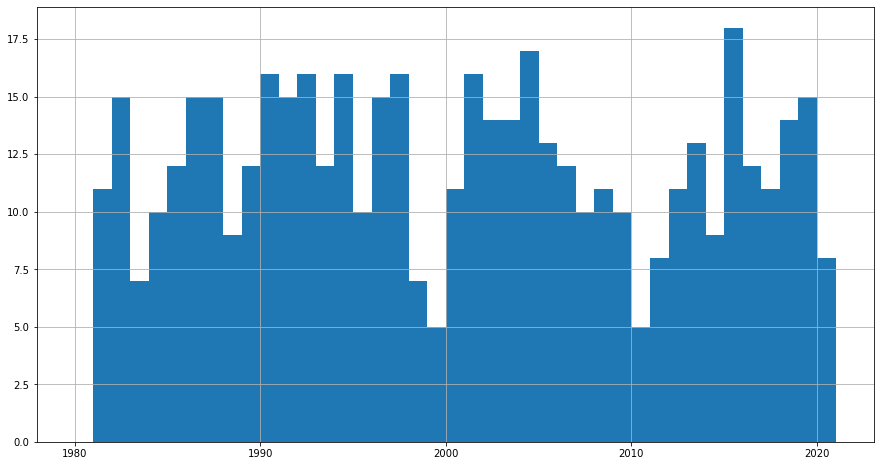

In [9]:
plt.hist(big.time[:,0].dt.year,bins=np.arange(1980,2022))
plt.grid()

# looking at cat 3 storm frequency in August

- since 2015 consistently more storms

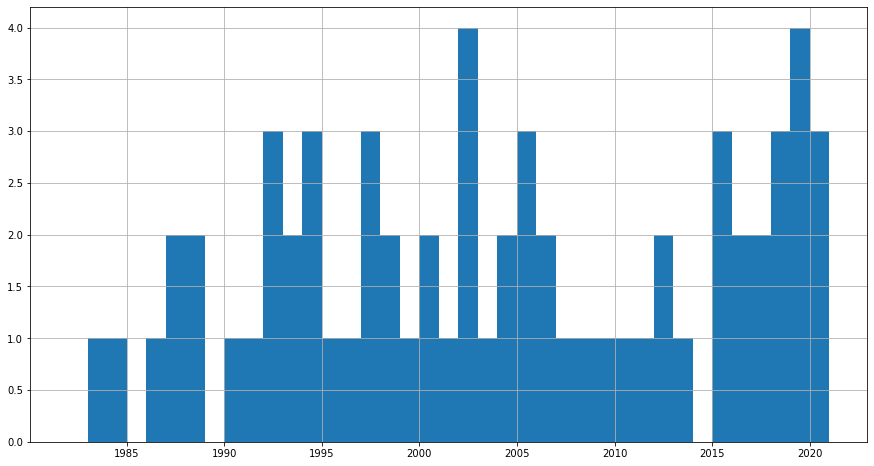

In [10]:
ds_storm['yr']=ds_storm.time[:,0].dt.year
ds_storm['mon']=ds_storm.time[:,0].dt.month
big = ds_storm.where((ds_storm.max_cat>=3) & (ds_storm.yr>1982) & (ds_storm.mon==8),drop=True)
plt.hist(big.time[:,0].dt.year,bins=np.arange(1982,2022))
big = ds_storm.where((ds_storm.max_cat>=3) & (ds_storm.yr>1982) & (ds_storm.mon==8),drop=True)
plt.hist(big.time[:,0].dt.year,bins=np.arange(1982,2022))
plt.grid()

In [ ]:
ds_storm

# monthly frequency of storms

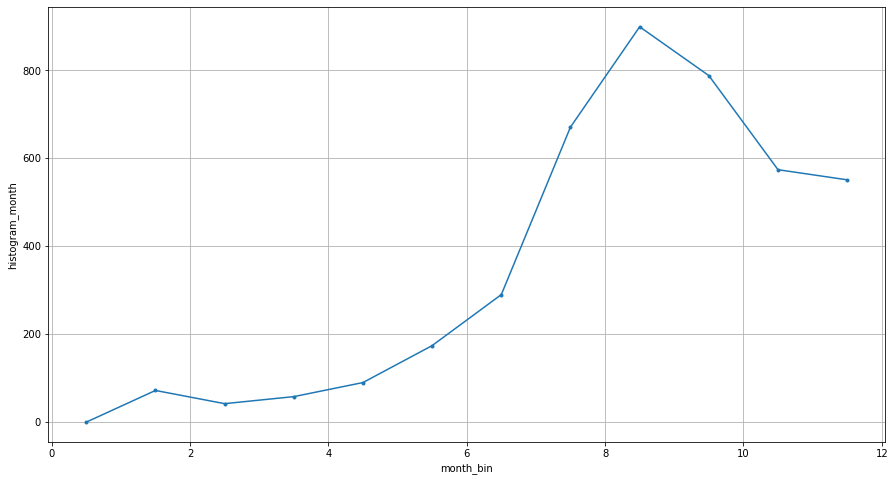

In [11]:
bins  = np.arange(0,13)
h = histogram(ds_storm.time[:,0].dt.month, bins=[bins])
h.plot(marker='.')
plt.grid()


# calculate histogram of number of storms per year

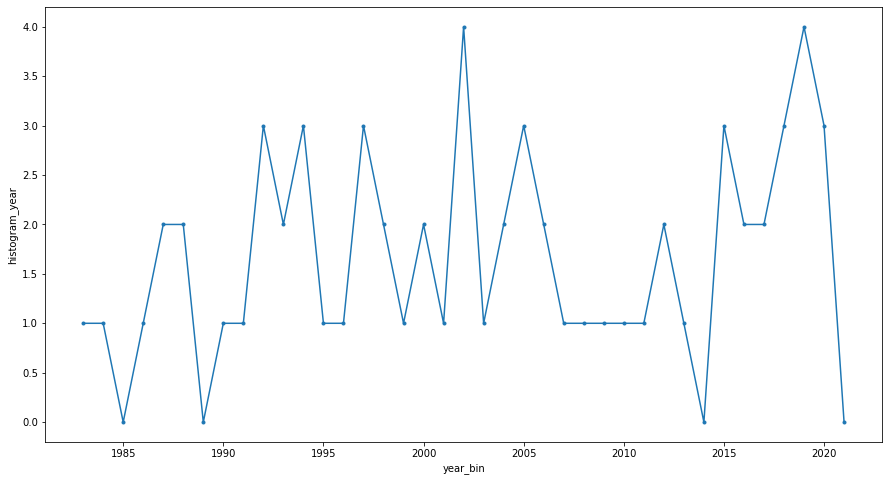

In [12]:
bins = np.arange(1982,2022)+.5
h = histogram(big.time[:,0].dt.year, bins=[bins])
h.plot(marker='.')

# read in NOAA OI SST

In [13]:
adir = 'F:/data/sat_data/sst/noaa_oisst/www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/'
dir_pattern_zarr = adir + 'avhrr_zarr2/'
ds_sst = xr.open_zarr(dir_pattern_zarr,consolidated=True)
ds_sst

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 14470)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 1981-09-01T12:00:00 ... 2021-04-13T12:00:00
    zlev     float32 ...
Data variables:
    anom     (time, lat, lon) float32 dask.array<chunksize=(1000, 300, 300), meta=np.ndarray>
    err      (time, lat, lon) float32 dask.array<chunksize=(1000, 300, 300), meta=np.ndarray>
    ice      (time, lat, lon) float32 dask.array<chunksize=(1000, 300, 300), meta=np.ndarray>
    sst      (time, lat, lon) float32 dask.array<chunksize=(1000, 300, 300), meta=np.ndarray>
Attributes: (12/37)
    Conventions:                CF-1.6, ACDD-1.3
    cdm_data_type:              Grid
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    creator_email:              oisst-help@noaa.gov
    creator_url:                https://www.ncei.noaa.gov/
    date_created:               2021-01-19T09:12:00Z
    ...                         ...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    standard_name_vocabulary:   CF Standard Name Table (v40, 25 January 2017)
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    time_coverage_end:          2021-01-04T23:59:59Z
    time_coverage_start:        2021-01-04T00:00:00Z
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...

In [14]:
%%time

sst_climatology = ds_sst.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)

sst_anomaly = ds_sst.groupby('time.dayofyear')-sst_climatology

sst_anomaly_monthly = sst_anomaly.resample(time='1MS').mean(keep_attrs=True,skipna=False)


Wall time: 46.4 s


# What does the SST data look like at a point near one of the storms origination point?

okay, that is noisy but looks like a jump up ~2000 and positive trend since 2010


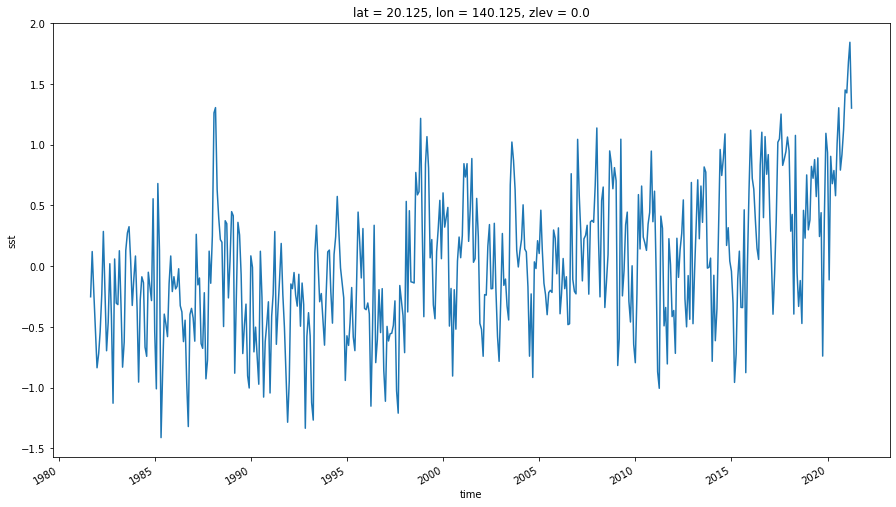

In [15]:
sst_anomaly_monthly.sst.sel(lon=140,lat=20,method='nearest').plot()
print('okay, that is noisy but looks like a jump up ~2000 and positive trend since 2010')

okay, definitiely getting warmer from 2015 onward


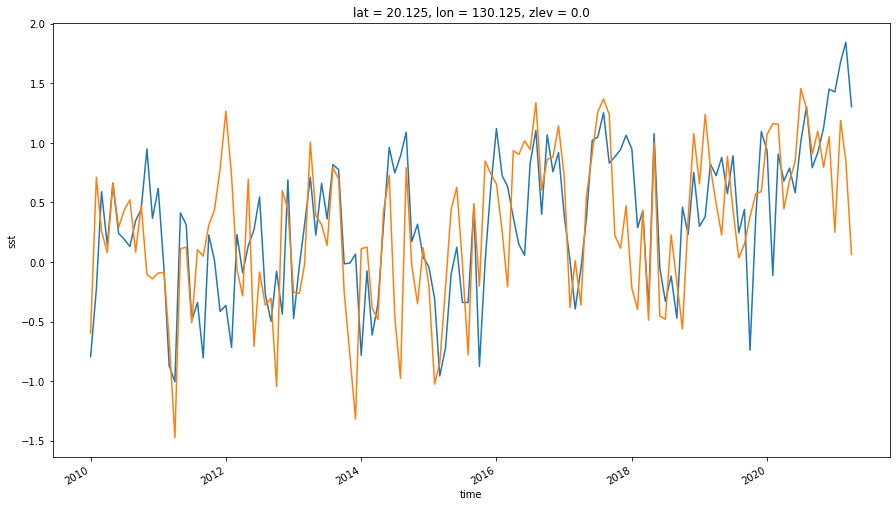

In [16]:
# plot monthly SST anomaly around where these storms started, zoom in on 2010 - present
sst_anomaly_monthly.sst.sel(lon=140.125,lat=20.125,time=slice('2010','2021')).plot()
sst_anomaly_monthly.sst.sel(lon=130.125,lat=20.125,time=slice('2010','2021')).plot()
print('okay, definitiely getting warmer from 2015 onward')

# let's just look at August SSTs

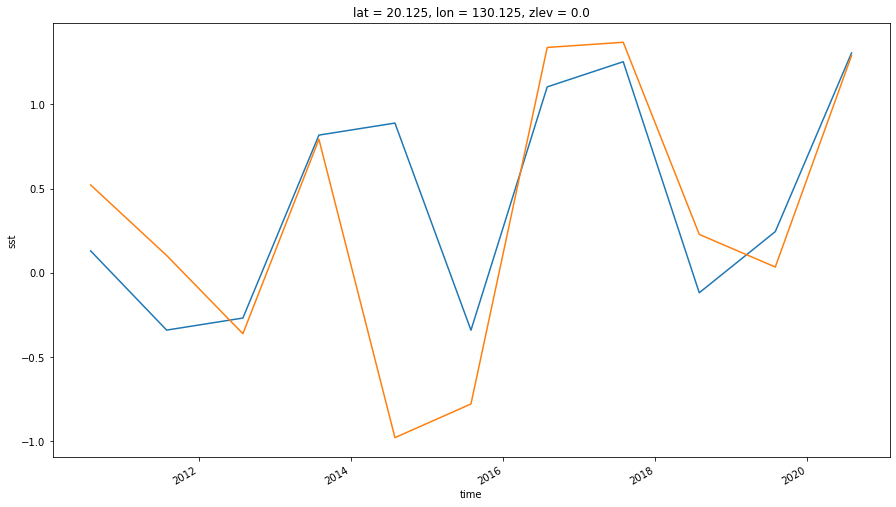

In [17]:
sst_anomaly_monthly.sst[11::12,:,:].sel(lon=140.125,lat=20.125,time=slice('2010','2021')).plot()
sst_anomaly_monthly.sst[11::12,:,:].sel(lon=130.125,lat=20.125,time=slice('2010','2021')).plot()

# What is the trend in August temperatures for this region?

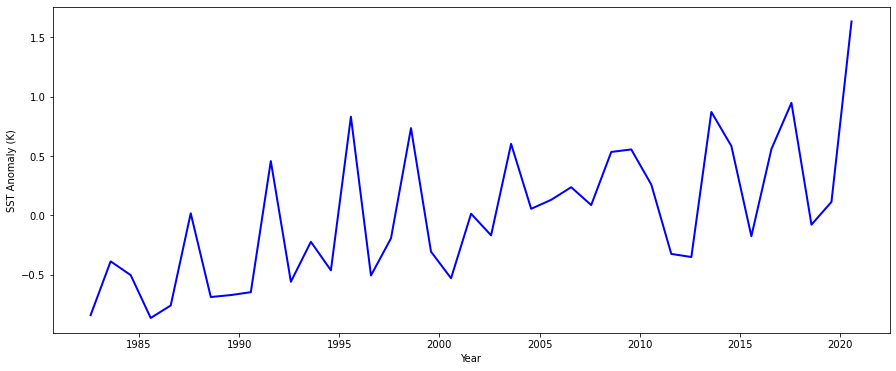

In [18]:
fig = plt.figure(figsize=(15,6))
ts = sst_anomaly_monthly.sst[11::12,:,:].sel(lon=slice(130,150),lat=slice(20,30)).mean({'lat','lon'})
plt.plot(ts.time,ts,linewidth=2,color='b')
plt.xlabel('Year')
plt.ylabel('SST Anomaly (K)')
plt.savefig('F:/data/project_data/fluxsat/korea/aug_sst_max_north_area.png')

# this is the region where all 3 storms started

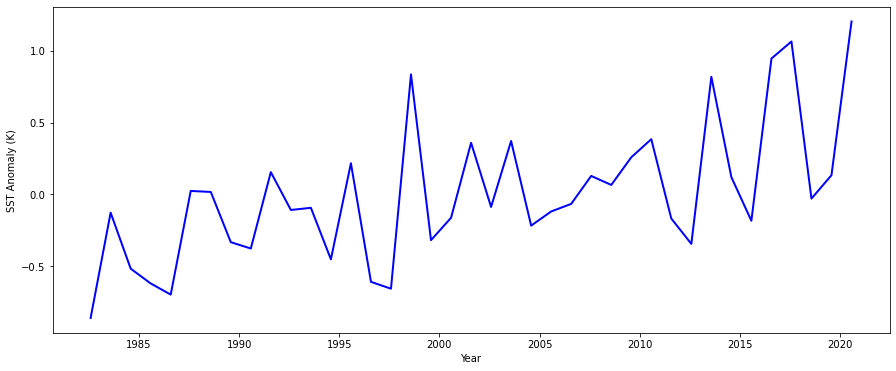

In [19]:
fig = plt.figure(figsize=(15,6))
dx=2
ts = sst_anomaly_monthly.sst[11::12,:,:].sel(lon=slice(120,145),lat=slice(15,25)).mean({'lat','lon'})
#ts = sst_anomaly_monthly.sst[11::12,:,:].sel(lon=slice(122-dx,145+dx),lat=slice(16-dx,23+dx)).mean({'lat','lon'})
plt.plot(ts.time,ts,linewidth=2,color='b')
plt.xlabel('Year')
plt.ylabel('SST Anomaly (K)')
plt.savefig('F:/data/project_data/fluxsat/korea/aug_sst.png')

# make west pacific subset and then save only august

In [20]:
wp = sst_anomaly_monthly.sel(lon=slice(80,175),lat=slice(0,45))
aug = wp.sst[11::12,:,:]

# plot anomaly 2020

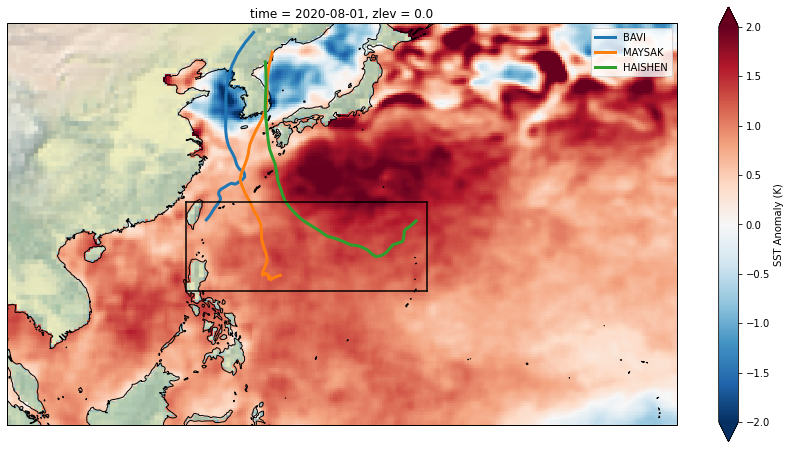

In [21]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
aug[-1,:,:].plot(vmin=-2,vmax=2,cmap='RdBu_r',transform=ccrs.PlateCarree(),cbar_kwargs={'label': 'SST Anomaly (K)'})
for i in ilist:
    ax.plot(ds_storm.lon[i,:],ds_storm.lat[i,:], transform=ccrs.PlateCarree(),label=ds_storm.name[i].data,linewidth=3)
ax.set_extent([100,175, 0, 45], crs=ccrs.PlateCarree())
ax.coastlines('50m')
ax.stock_img()
ax.legend()
r1,r2,r3,r4 = 120,147,15,25
ax.plot([r1,r1],[r3,r4],'k', transform=ccrs.PlateCarree())
ax.plot([r2,r2],[r3,r4],'k', transform=ccrs.PlateCarree())
ax.plot([r1,r2],[r3,r3],'k', transform=ccrs.PlateCarree())
ax.plot([r1,r2],[r4,r4],'k', transform=ccrs.PlateCarree())

In [22]:
print(min(ds_storm.lon[ilist,0].data),max(ds_storm.lon[ilist,0].data),min(ds_storm.lat[ilist,0].data),max(ds_storm.lat[ilist,0].data))

122.3 145.8 16.8 23.0


In [23]:
#import xarray as xr
#from xmovie import Movie

#mov = Movie(wp.sst[11::12,:,:],cmap='RdBu_r',vmin=-2,vmax=2)
#mov.save('f:/data/sst_westpacB.mp4')

# What are the historical temperatures where these storms formed?

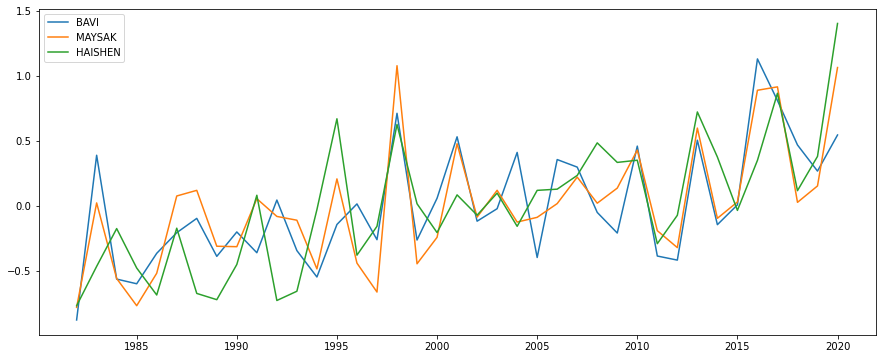

In [24]:
fig = plt.figure(figsize=(15,6))
for i in ilist:
    xlon = ds_storm.lon[i,0].data
    xlat = ds_storm.lat[i,0].data
    ts = wp.sel(lat=slice(xlat-5,xlat+15),lon=slice(xlon-15,xlon+5)).mean({'lat','lon'})
    plt.plot(ts.time.dt.year[11::12],ts.sst[11::12],label=ds_storm.name[i].data)
plt.legend()

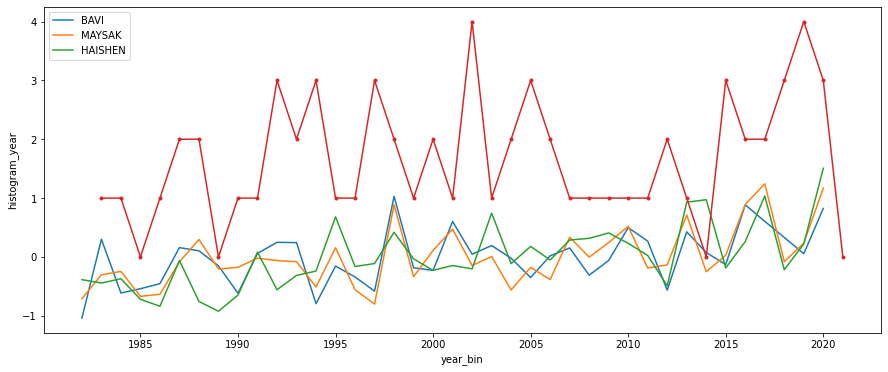

In [25]:
fig = plt.figure(figsize=(15,6))
for i in ilist:
    xlon = ds_storm.lon[i,0].data
    xlat = ds_storm.lat[i,0].data
    ts = wp.sel(lat=slice(xlat-5,xlat+5),lon=slice(xlon-5,xlon+5)).mean({'lat','lon'})
    plt.plot(ts.time.dt.year[11::12],ts.sst[11::12],label=ds_storm.name[i].data)
plt.legend()
h.plot(marker='.')

In [26]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from eofs.xarray import Eof
from eofs.examples import example_data_path


# load SST monthly anomaly for august
- this is a small enough dataset that to make everything faster we can just load into memory and avoid chuncking issues

In [27]:
sst = sst_anomaly_monthly.anom[11::12,:,:].load()  #AUGUST

# remove mean and trend
- detrend the data and put back into xr.DataArray & fill back in nan
- sst2 = sst_debias - sst_slope.slope*sst_debias


# plot SST trend

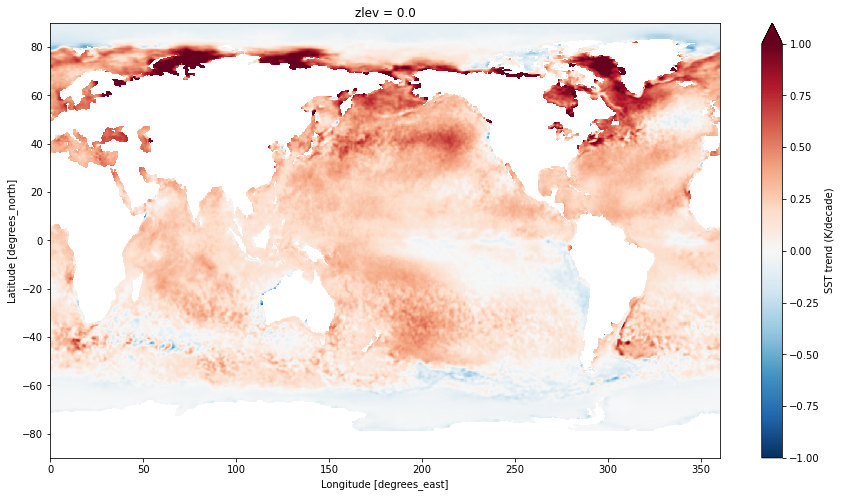

In [29]:
sst_debias = sst - sst.mean({'time'})
sst2 = signal.detrend(sst_debias.fillna(0),axis=0,type='linear')
sst2 = xr.DataArray(sst2,dims=['time','lat','lon'],coords={'time':sst_debias.time,'lat':sst_debias.lat,'lon':sst_debias.lon})
sst2 = sst2.where(~np.isnan(sst))
dif = sst_debias-sst2 #cal difference between sst with bias removed and sst with trend removed
((dif.sel(time='2010-08-01')-dif.sel(time='2000-08-01'))).plot(vmin=-1,vmax=1,cmap='RdBu_r',cbar_kwargs={'label': 'SST trend (K/decade)'})

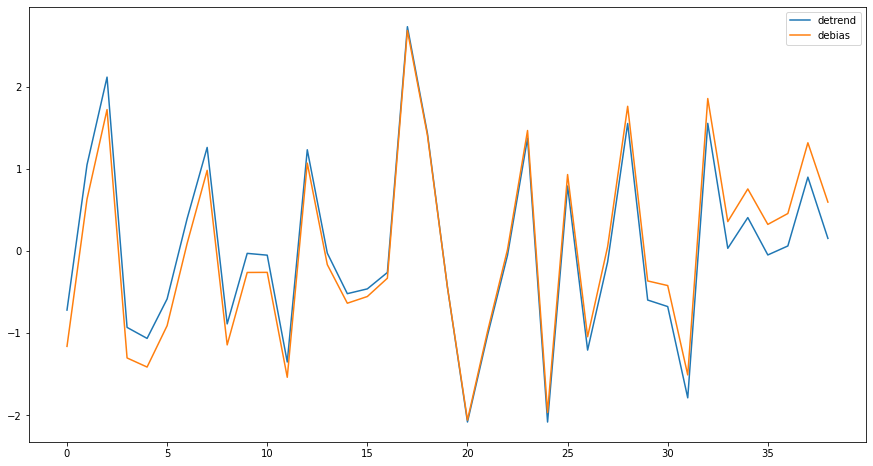

In [30]:
plt.plot(sst2.sel(lon=150,lat=40,method='nearest'),label='detrend')
plt.plot(sst_debias.sel(lon=150,lat=40,method='nearest'),label='debias')
plt.legend()

Text(0.5, 1.0, 'PC1 Time Series')

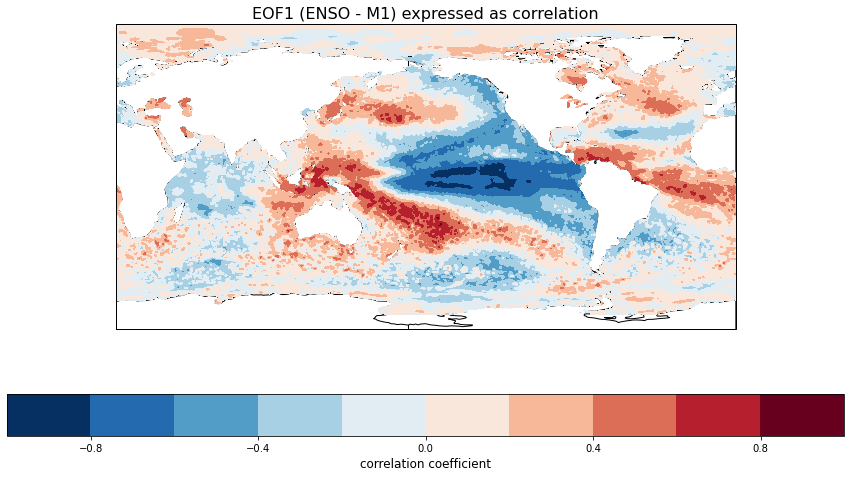

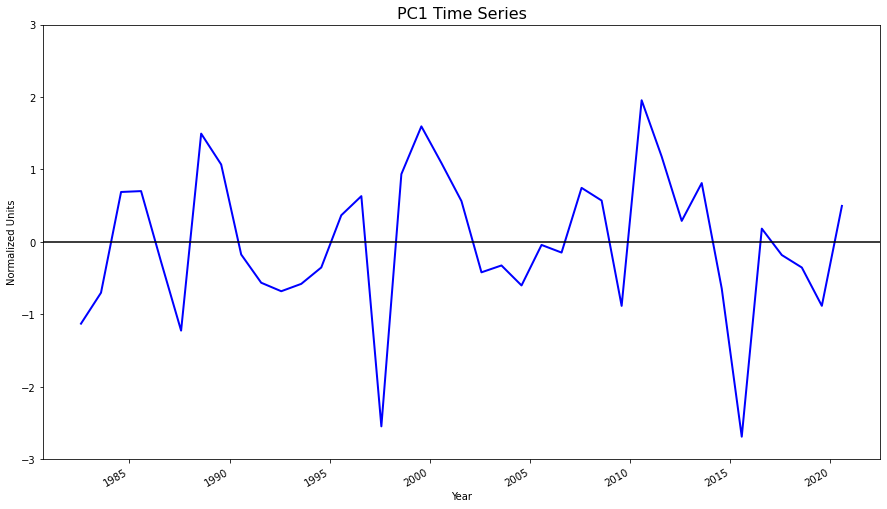

In [31]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(sst2.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst2, weights=wgts)

# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
eof1 = solver.eofsAsCorrelation(neofs=5)
pc1 = solver.pcs(npcs=5, pcscaling=1)

# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF1 (ENSO - M1) expressed as correlation', fontsize=16)

# Plot the leading PC time series.
plt.figure()
pc1[:, 0].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)


Text(0.5, 1.0, 'PC2 Time Series')

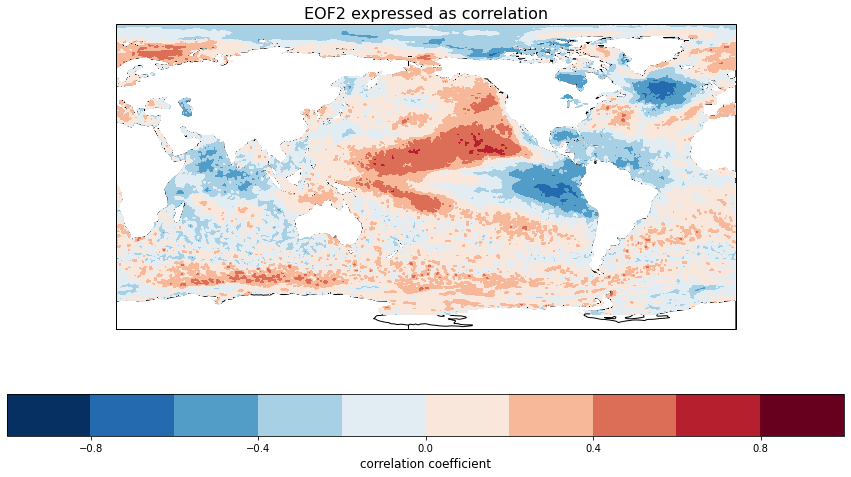

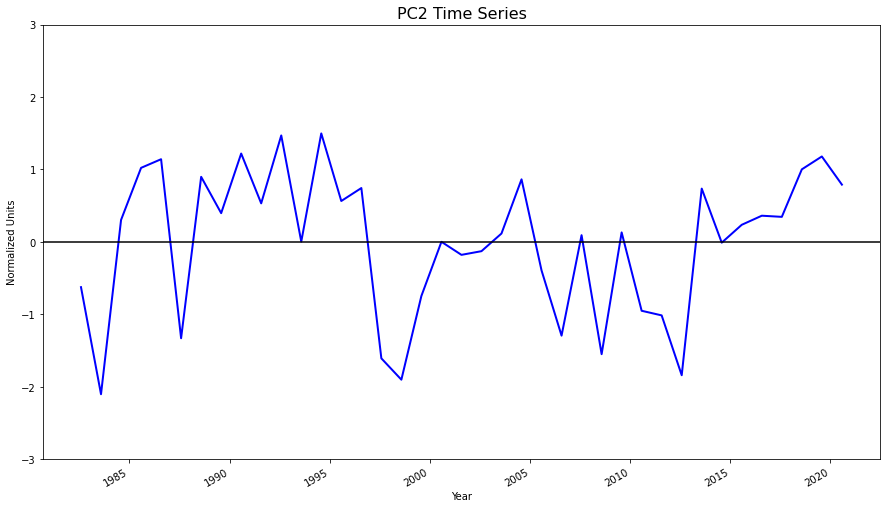

In [32]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF2 expressed as correlation', fontsize=16)

# Plot the leading PC time series.
plt.figure()
pc1[:, 1].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC2 Time Series', fontsize=16)

Text(0.5, 1.0, 'PC3 Time Series')

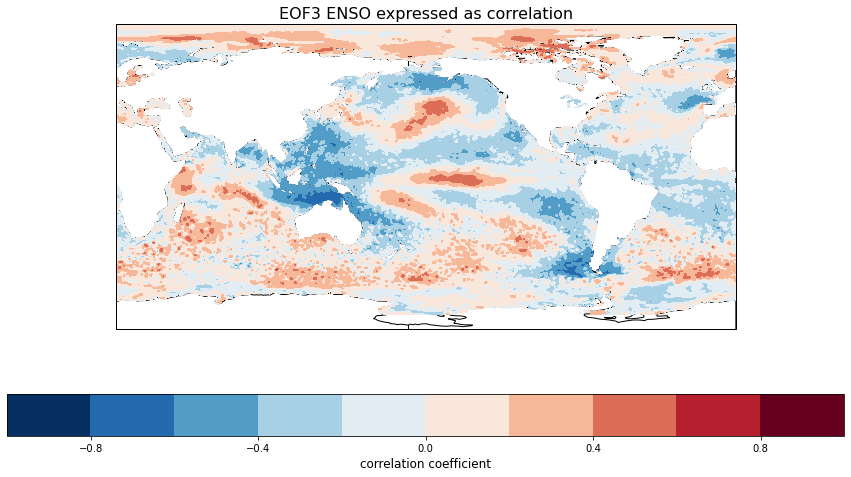

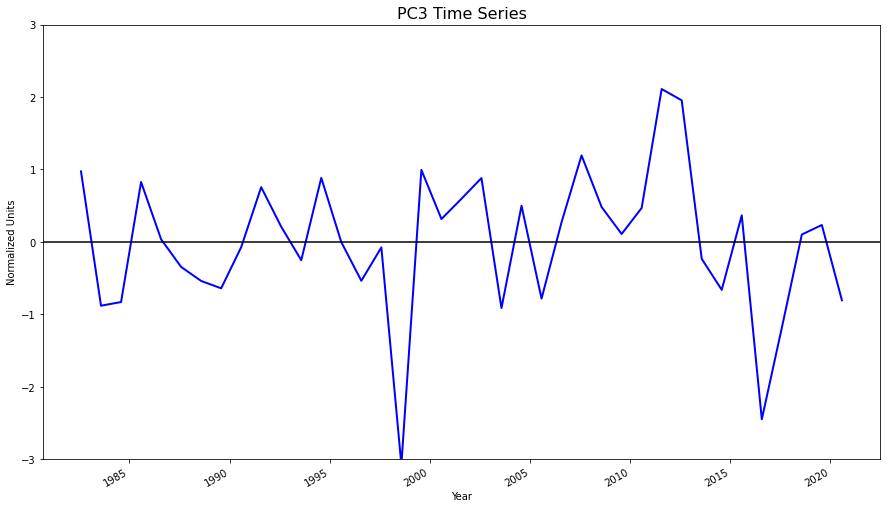

In [33]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[2].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF3 ENSO expressed as correlation', fontsize=16)

# Plot the leading PC time series.
plt.figure()
pc1[:, 2].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC3 Time Series', fontsize=16)

Text(0.5, 1.0, 'PC4 Time Series')

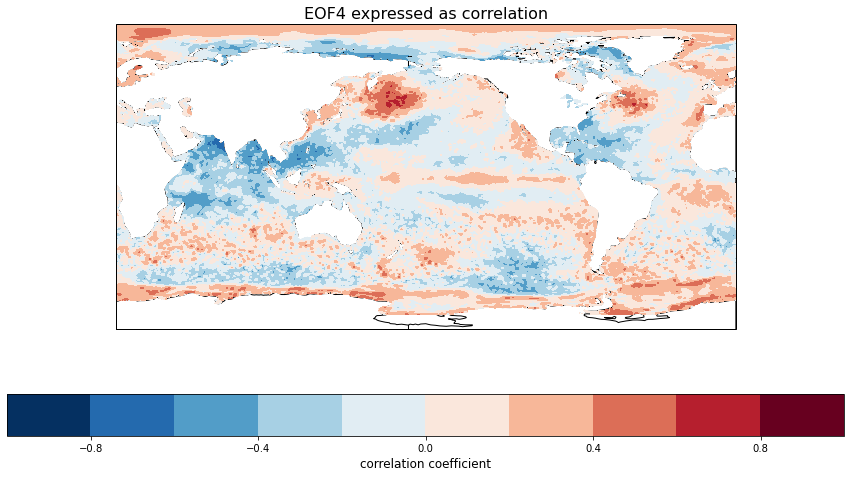

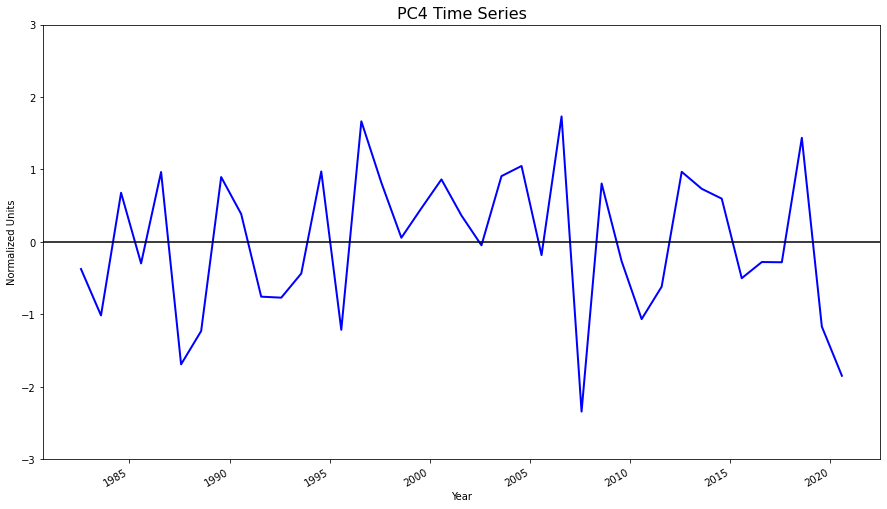

In [34]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[3].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF4 expressed as correlation', fontsize=16)

# Plot the leading PC time series.
plt.figure()
pc1[:, 3].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC4 Time Series', fontsize=16)

# reconstruct data

In [35]:
reconstructed_data0 = solver.reconstructedField(0)
reconstructed_data1 = solver.reconstructedField(1)
reconstructed_data2 = solver.reconstructedField(2)
reconstructed_data3 = solver.reconstructedField(3)
reconstructed_data4 = solver.reconstructedField(4)

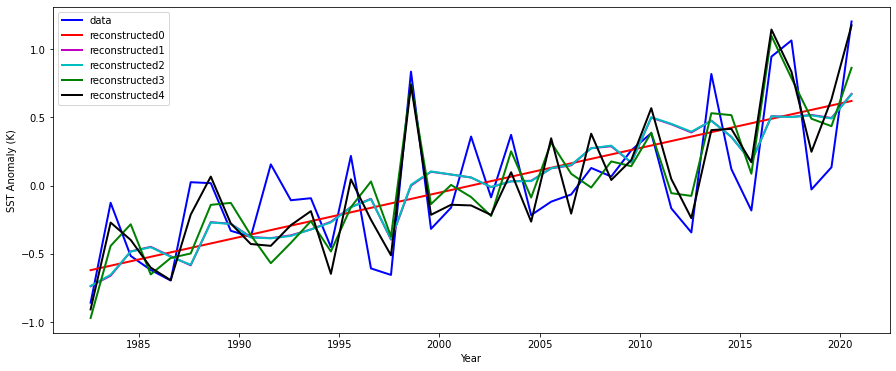

In [36]:
r1,r2,r3,r4 = 120,145,15,25
fig = plt.figure(figsize=(15,6))
#ts = sst_anomaly_monthly.sst[11::12,:,:].sel(lon=slice(130,150),lat=slice(20,30)).mean({'lat','lon'})
ts = sst_anomaly_monthly.sst[11::12,:,:].sel(lon=slice(r1,r2),lat=slice(r3,r4)).mean({'lat','lon'})
plt.plot(ts.time,ts,linewidth=2,color='b',label='data')
ts0 = reconstructed_data0.sel(lon=slice(r1,r2),lat=slice(r3,r4)).mean({'lat','lon'})
ts1 = reconstructed_data1.sel(lon=slice(r1,r2),lat=slice(r3,r4)).mean({'lat','lon'})
ts2 = reconstructed_data2.sel(lon=slice(r1,r2),lat=slice(r3,r4)).mean({'lat','lon'})
ts3 = reconstructed_data3.sel(lon=slice(r1,r2),lat=slice(r3,r4)).mean({'lat','lon'})
ts4 = reconstructed_data4.sel(lon=slice(r1,r2),lat=slice(r3,r4)).mean({'lat','lon'})
ts_trend = dif.sel(lon=slice(130,150),lat=slice(20,30)).mean({'lat','lon'})
plt.plot(ts.time,ts0+ts_trend,linewidth=2,color='r',label='reconstructed0')
plt.plot(ts.time,ts1+ts_trend,linewidth=2,color='m',label='reconstructed1')
plt.plot(ts.time,ts2+ts_trend,linewidth=2,color='c',label='reconstructed2')
plt.plot(ts.time,ts3+ts_trend,linewidth=2,color='g',label='reconstructed3')
plt.plot(ts.time,ts4+ts_trend,linewidth=2,color='k',label='reconstructed4')
plt.xlabel('Year')
plt.ylabel('SST Anomaly (K)')
plt.legend()
plt.savefig('F:/data/project_data/fluxsat/korea/aug_sst_reconstructed.png')

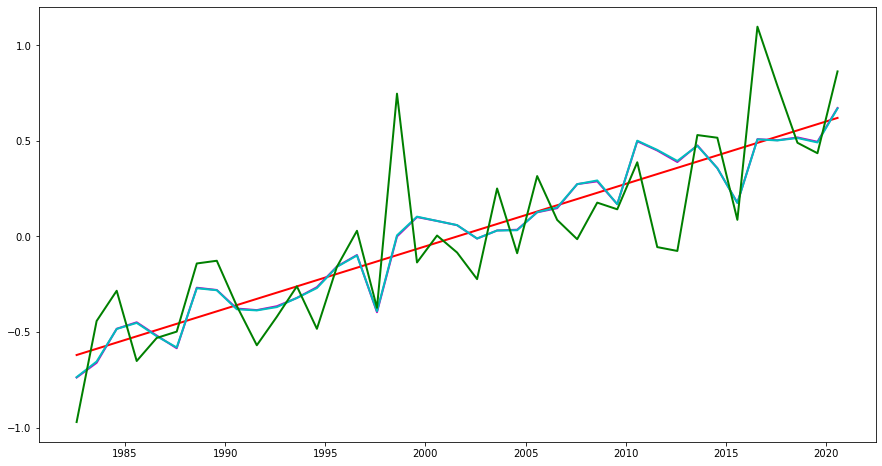

In [37]:
plt.plot(ts.time,ts0+ts_trend,linewidth=2,color='r',label='reconstructed1')
plt.plot(ts.time,ts1+ts_trend,linewidth=2,color='m',label='reconstructed1')
plt.plot(ts.time,ts2+ts_trend,linewidth=2,color='c',label='reconstructed1')
plt.plot(ts.time,ts3+ts_trend,linewidth=2,color='g',label='reconstructed1')


# what does buoy data look like?

In [38]:
fname='https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/52211/52211.ncml'
ds_buoy = xr.open_dataset(fname).rename({'latitude':'lat','longitude':'lon'})
ds_buoy['mon']=ds_buoy.time.dt.month
#ds_buoy

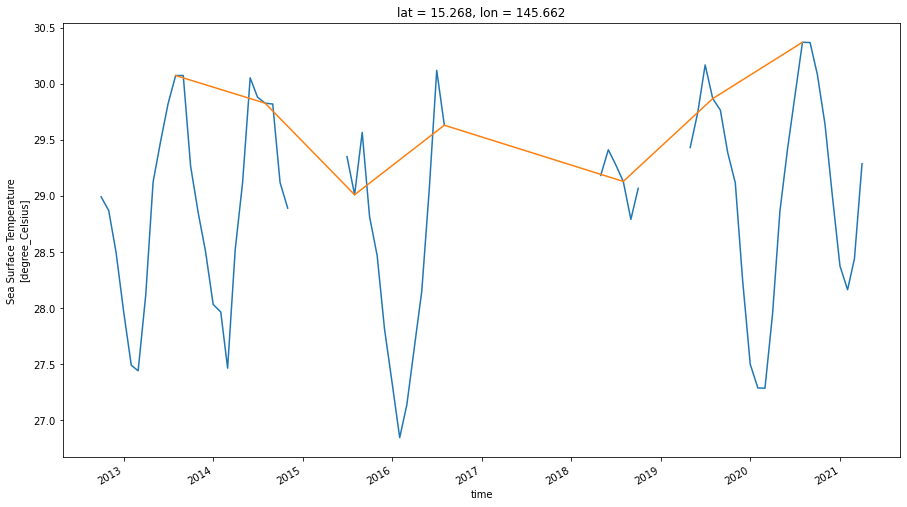

In [39]:
ds_buoy_month = ds_buoy.resample(time='1MS').mean(keep_attrs=True,skipna=True)
ds_buoy_month.sea_surface_temperature.plot()
buoy_aug = ds_buoy_month.where(ds_buoy_month.mon==8,drop=True)
buoy_aug.sea_surface_temperature.plot()

In [44]:
#too slow
buoy_clim = sst_climatology.sst.sel(lat=ds_buoy.lat,lon=ds_buoy.lon,method='nearest')
sst_anomaly_buoy = ds_buoy.sea_surface_temperature.groupby('time.dayofyear')-buoy_clim[:,0,0]
sst_anomaly_buoy_monthly = sst_anomaly_buoy.resample(time='1MS').mean(keep_attrs=True,skipna=True)
sst_anomaly_buoy_monthly[10::12].plot()
plt.ylabel('SST anomaly (K)')
print(sst_anomaly_buoy_monthly[10::12].load().data[-1])

KeyboardInterrupt: 

# plot NOAA OI SST, reconstructed SST, and buoy SST all at buoy SST location
- Just a note - if they don't agree there is something probably wrong because NOAA OI SSTs uses in situ data in their analysis

NameError: name 'sst_anomaly_buoy_monthly' is not defined

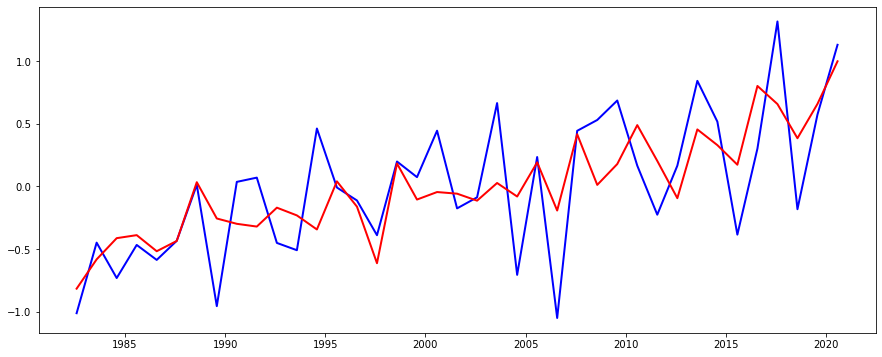

In [42]:
fig = plt.figure(figsize=(15,6))
ts = sst_anomaly_monthly.sst[11::12,:,:].sel(lat=ds_buoy.lat,lon=ds_buoy.lon,method='nearest')
plt.plot(ts.time,ts[:,0,0],linewidth=2,color='b',label='data')
ts = reconstructed_data4.sel(lat=ds_buoy.lat,lon=ds_buoy.lon,method='nearest')
ts_trend = dif.sel(lat=ds_buoy.lat,lon=ds_buoy.lon,method='nearest')
plt.plot(ts.time,ts[:,0,0]+ts_trend[:,0,0],linewidth=2,color='r',label='reconstructed')
sst_anomaly_buoy_monthly[10::12].plot(color='k',marker='.',label='buoy')
plt.xlabel('Year')
plt.ylabel('SST Anomaly (K)')
plt.legend()
plt.savefig('F:/data/project_data/fluxsat/korea/aug_sst_reconstructed_buoy.png')

# so what is going on? are all months warming like this?

In [ ]:
for imon in range(12):
    imon2 = imon+4
    sst = sst_anomaly_monthly.anom[imon2::12,:,:].load()  #monthly
    sst_debias = sst - sst.mean({'time'})
    sst2 = signal.detrend(sst_debias.fillna(0),axis=0,type='linear')
    sst2 = xr.DataArray(sst2,dims=['time','lat','lon'],coords={'time':sst_debias.time,'lat':sst_debias.lat,'lon':sst_debias.lon})
    sst2 = sst2.where(~np.isnan(sst))
    dif = sst_debias-sst2 #cal difference between sst with bias removed and sst with trend removed
    time0,time1='2010-'+str(imon+1).zfill(2)+'-01','2000-'+str(imon+1).zfill(2)+'-01'
    ((dif.sel(time=time0)-dif.sel(time=time1))).plot(vmin=-1,vmax=1,cmap='RdBu_r',cbar_kwargs={'label': 'SST trend (K/decade)'})
    plt.savefig('F:/data/project_data/fluxsat/korea/sst_trend_mon'+str(imon+1)+'.png')
    plt.clf()
    

# when are SSTs warm enough for TCs?
- TC require SST > 26.5  ref: https://journals.ametsoc.org/view/journals/clim/28/20/jcli-d-14-00637.1.xml
- so write a function that calculates fraction of days in a month that SSTs >26.5
- then once that is working, caluclate it for each year
- then calculate if there is a trend in # days

In [ ]:
def fracdy(x):
    return (((x.where(x>26.5)/x).sum({'time'}))/x.sizes['time'])
def numdy(x):
    return ((x.where(x>26.5)/x).sum({'time'}))
frac = ds_sst.sst.groupby('time.month').map(fracdy)
num = ds_sst.sst.groupby('time.month').map(numdy)

In [ ]:
frac_yr = []
for lyr in range(1982,2021):
    tem = ds_sst.sst.sel(time=str(lyr))
    frac = tem.groupby('time.month').map(fracdy)
    frac_yr.append(frac)
frac_yr = xr.concat(frac_yr, dim='time')
frac_yr['time']=np.arange(1982,2021)

In [ ]:
r1,r2,r3,r4 = 120,145,15,25
ts =frac_yr.isel(month=6).sel(lon=r2,lat=r4,method='nearest')
f = (ts.sel(time=slice(2015,2020)).mean()-ts.sel(time=slice(1985,1990)).mean()).load()
print(f)

In [ ]:
ts =frac_yr.isel(month=7)
f = (ts.sel(time=slice(2015,2020)).mean('time')-ts.sel(time=slice(1985,1990)).mean('time')).load()
fig = plt.figure(figsize=(15,6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
f.plot(vmin=-.75,vmax=.75,cmap='RdBu_r',transform=ccrs.PlateCarree())
#ax.set_extent([110, 150, 10, 60], crs=ccrs.PlateCarree())
ax.coastlines('50m')
ax.stock_img()

In [ ]:
ts.sel(lat=25,lon=145,method='nearest').plot()

In [ ]:
ts_debias = ts - ts.mean({'time'})
ts2 = signal.detrend(ts_debias.fillna(0),axis=0,type='linear')

In [ ]:
time0,time1=2010,2000
dif = ts_debias-ts2 #cal difference between sst with bias removed and sst with trend removed
f = ((dif.sel(time=time0)-dif.sel(time=time1))) #.plot(vmin=-.25,vmax=.25,cmap='RdBu_r',cbar_kwargs={'label': 'SST trend (K/decade)'})
fig = plt.figure(figsize=(15,6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
f.plot(vmin=-.25,vmax=.25,cmap='RdBu_r',transform=ccrs.PlateCarree())
#ax.set_extent([110, 150, 10, 60], crs=ccrs.PlateCarree())
ax.coastlines('50m')
ax.stock_img()

In [ ]:
big

In [ ]:
sub = ds_storm.where((ds_storm.max_wind>50) & (ds_storm.yr>1980))
plt.scatter(sub.lon[:,0],sub.lat[:,0],c=sub.yr)
plt.colorbar()

In [ ]:
hh=[]
for iyr in range(1980,2021):
    sub = ds_storm.where((ds_storm.max_wind>50) & (ds_storm.yr==1980),drop=True)
    h = plt.hist(sub.lat[:,0],bins=np.arange(0,40,2))
    h1 = xr.DataArray(h[0]/sum(h[0]),coords={'lat':h[1][:-1]},dims=('lat'))
    hh.append(h1)

In [ ]:
h2 = xr.concat(hh,dim='year')

In [ ]:
plt.plot(h2[:,0])

In [ ]:
h

In [47]:
# can i get average sst at the locations the storms went over their first 5-10 days?
big = ds_storm.where((ds_storm.max_cat>=3) & (ds_storm.yr>1982) & (ds_storm.mon==8),drop=True)
big

<xarray.Dataset>
Dimensions:           (date_time: 360, quadrant: 4, storm: 65)
Coordinates:
    time              (storm, date_time) datetime64[ns] 1983-08-27T00:00:00.0...
    lat               (storm, date_time) float32 ...
    lon               (storm, date_time) float32 ...
Dimensions without coordinates: date_time, quadrant, storm
Data variables: (12/151)
    numobs            (storm) float32 115.0 95.0 161.0 85.0 ... 47.0 51.0 57.0
    sid               (storm) object '1983239N10183' ... '2020245N23146'
    season            (storm) float32 1.983e+03 1.984e+03 ... 2.02e+03 2.02e+03
    number            (storm) float64 52.0 69.0 78.0 52.0 ... 59.0 62.0 65.0
    basin             (storm, date_time) object 'EP' 'EP' 'EP' 'EP' ... '' '' ''
    subbasin          (storm, date_time) object 'CP' 'CP' 'CP' 'CP' ... '' '' ''
    ...                ...
    storm_speed       (storm, date_time) float32 16.0 16.0 16.0 ... nan nan nan
    storm_dir         (storm, date_time) float32 285.0 285.0 287.0 ... nan nan
    max_wind          (storm) float32 125.0 125.0 110.0 ... 99.0 124.0 134.0
    max_cat           (storm) float32 4.0 4.0 3.0 5.0 4.0 ... 4.0 3.0 4.0 4.0
    yr                (storm) float64 1.983e+03 1.984e+03 ... 2.02e+03 2.02e+03
    mon               (storm) float64 8.0 8.0 8.0 8.0 8.0 ... 8.0 8.0 8.0 8.0
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [49]:
ds_storm


<xarray.Dataset>
Dimensions:           (date_time: 360, quadrant: 4, storm: 4209)
Coordinates:
    time              (storm, date_time) datetime64[ns] 1884-06-24T16:00:00.0...
    lat               (storm, date_time) float32 ...
    lon               (storm, date_time) float32 ...
Dimensions without coordinates: date_time, quadrant, storm
Data variables: (12/151)
    numobs            (storm) float32 56.0 46.0 46.0 46.0 ... 19.0 31.0 39.0
    sid               (storm) <U13 '1884177N17124' ... '2021048N07133'
    season            (storm) float32 1.884e+03 1.884e+03 ... 2.02e+03 2.021e+03
    number            (storm) int16 14 16 17 21 22 23 25 ... 93 95 98 99 111 14
    basin             (storm, date_time) <U2 'WP' 'WP' 'WP' 'WP' ... '' '' '' ''
    subbasin          (storm, date_time) <U2 'MM' 'MM' 'MM' 'MM' ... '' '' '' ''
    ...                ...
    storm_speed       (storm, date_time) float32 ...
    storm_dir         (storm, date_time) float32 ...
    max_wind          (storm) float32 nan nan nan nan ... 115.0 39.0 29.0 45.0
    max_cat           (storm) float32 -1.0 -1.0 -1.0 -1.0 ... 4.0 0.0 -1.0 0.0
    yr                (storm) int64 1884 1884 1884 1884 ... 2020 2020 2020 2021
    mon               (storm) int64 6 7 7 7 7 8 8 8 8 ... 10 10 10 10 11 11 12 2
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [52]:
#big2 is for all storms that START in august
#sub2 is for all storms that have any data in august
ds_storm['yr']=ds_storm.time[:,0].dt.year
ds_storm['mon']=ds_storm.time[:,0].dt.month
#subset to cat 3 & post 1982
big = ds_storm.where((ds_storm.max_cat>=3) & (ds_storm.yr>1982),drop=True)
big2 = ds_storm.where((ds_storm.max_cat>=3) & (ds_storm.yr>1982) & (ds_storm.mon==8),drop=True)
#subset to any storm that has any data in august
sub = []
for istorm in range(0,len(big.storm)-1):
    tem = big.isel(storm=istorm)
    if any(tem.time.dt.month==8):
        sub.append(tem)
sub2 = xr.concat(sub,dim='storm')
# collocate SST anomaly with storm info
big2['sst_anom']=sst_anomaly.sst.interp(lat=big2.lat,lon=big2.lon,time=big2.time).compute()

<xarray.Dataset>
Dimensions:           (date_time: 360, quadrant: 4, storm: 347)
Coordinates:
    time              (storm, date_time) datetime64[ns] 1983-07-20T00:00:00.0...
    lat               (storm, date_time) float32 ...
    lon               (storm, date_time) float32 ...
Dimensions without coordinates: date_time, quadrant, storm
Data variables: (12/151)
    numobs            (storm) float32 49.0 115.0 119.0 113.0 ... 35.0 75.0 51.0
    sid               (storm) object '1983201N08144' ... '2020314N12131'
    season            (storm) float32 1.983e+03 1.983e+03 ... 2.02e+03 2.02e+03
    number            (storm) float64 35.0 52.0 58.0 82.0 ... 92.0 93.0 98.0
    basin             (storm, date_time) object 'WP' 'WP' 'WP' 'WP' ... '' '' ''
    subbasin          (storm, date_time) object 'MM' 'MM' 'MM' 'MM' ... '' '' ''
    ...                ...
    storm_speed       (storm, date_time) float32 15.0 15.0 15.0 ... nan nan nan
    storm_dir         (storm, date_time) float32 295.0 293.0 290.0 ... nan nan
    max_wind          (storm) float32 135.0 125.0 150.0 ... 109.0 169.0 115.0
    max_cat           (storm) float32 4.0 4.0 5.0 3.0 4.0 ... 4.0 3.0 5.0 4.0
    yr                (storm) float64 1.983e+03 1.983e+03 ... 2.02e+03 2.02e+03
    mon               (storm) float64 7.0 8.0 9.0 11.0 ... 8.0 10.0 10.0 11.0
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

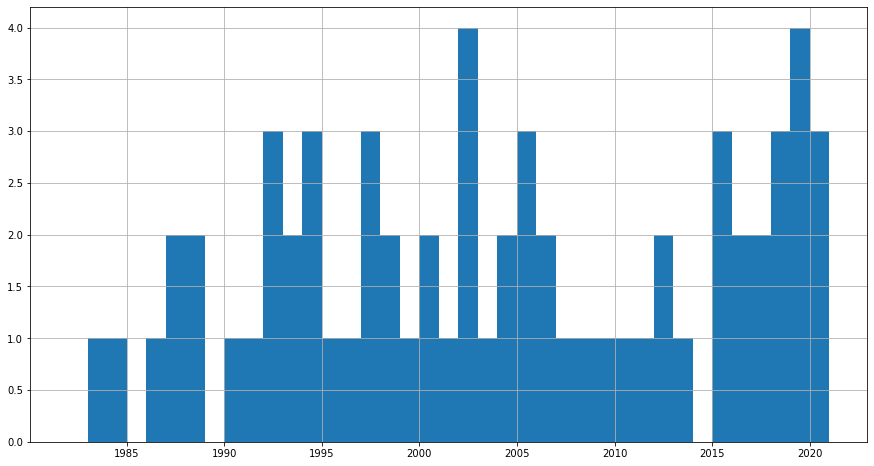

In [96]:
#plt.hist(sub2.time[:,0].dt.year,bins=np.arange(1982,2022))
#plt.grid()
plt.hist(big2.time[:,0].dt.year,bins=np.arange(1982,2022))
plt.grid()

# Plot SST anomalies along storm track

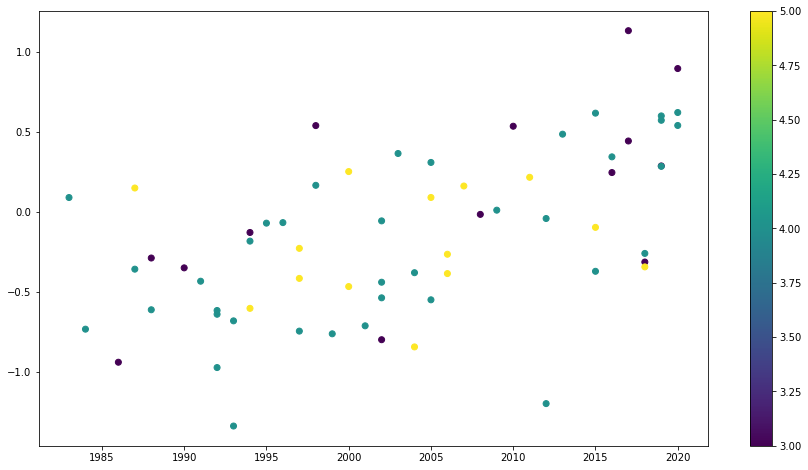

In [106]:
plt.scatter(big2.yr,big2.sst_anom.mean('date_time'),c=big2.max_cat)
plt.colorbar()

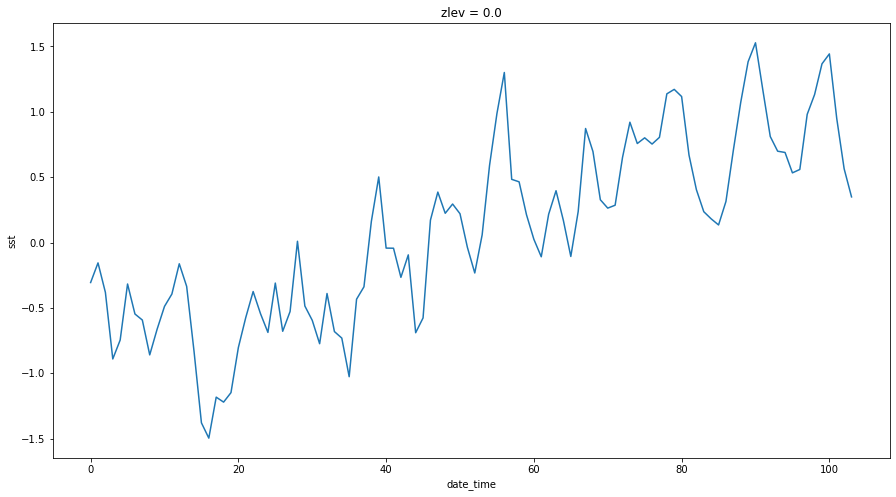

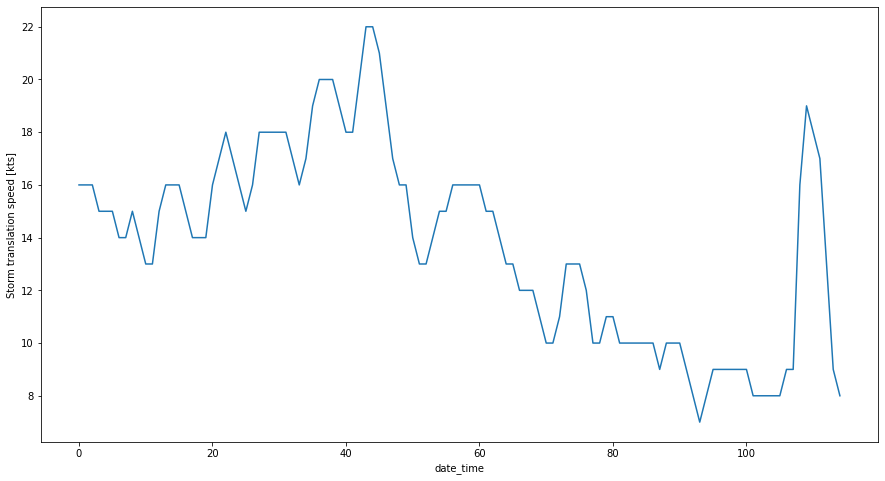

In [85]:
big2.storm_speed[0,:].plot()

In [86]:
big2

<xarray.Dataset>
Dimensions:           (date_time: 360, quadrant: 4, storm: 65)
Coordinates:
    time              (storm, date_time) datetime64[ns] 1983-08-27T00:00:00.0...
    lat               (storm, date_time) float32 9.8 10.0 10.21 ... nan nan nan
    lon               (storm, date_time) float32 183.2 182.4 181.7 ... nan nan
Dimensions without coordinates: date_time, quadrant, storm
Data variables: (12/151)
    numobs            (storm) float32 115.0 95.0 161.0 85.0 ... 47.0 51.0 57.0
    sid               (storm) object '1983239N10183' ... '2020245N23146'
    season            (storm) float32 1.983e+03 1.984e+03 ... 2.02e+03 2.02e+03
    number            (storm) float64 52.0 69.0 78.0 52.0 ... 59.0 62.0 65.0
    basin             (storm, date_time) object 'EP' 'EP' 'EP' 'EP' ... '' '' ''
    subbasin          (storm, date_time) object 'CP' 'CP' 'CP' 'CP' ... '' '' ''
    ...                ...
    storm_speed       (storm, date_time) float32 16.0 16.0 16.0 ... nan nan nan
    storm_dir         (storm, date_time) float32 285.0 285.0 287.0 ... nan nan
    max_wind          (storm) float32 125.0 125.0 110.0 ... 99.0 124.0 134.0
    max_cat           (storm) float32 4.0 4.0 3.0 5.0 4.0 ... 4.0 3.0 4.0 4.0
    yr                (storm) float64 1.983e+03 1.984e+03 ... 2.02e+03 2.02e+03
    mon               (storm) float64 8.0 8.0 8.0 8.0 8.0 ... 8.0 8.0 8.0 8.0
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3